## Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
import pickle
from tqdm import tqdm_notebook
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import  cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import *
from prettytable import PrettyTable
from sklearn.externals import  joblib

## Load preprocessed data 

In [3]:
#Functions to save objects for later use and retireve it
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".pkl","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".pkl","rb"))
    return temp

y_train =openfromfile('y_train')
y_test =openfromfile('y_test')

count_vect =openfromfile('count_vect')
X_train_bigram = openfromfile('X_train_bigram')
X_test_bigram = openfromfile('X_test_bigram')

count_vect_fe =openfromfile('count_vect_fe')
X_train_bigram_fe = openfromfile('X_train_bigram_fe')
X_test_bigram_fe = openfromfile('X_test_bigram_fe')

tf_idf_vect =openfromfile('tf_idf_vect')
X_train_tfidf =openfromfile('X_train_tfidf')
X_test_tfidf =openfromfile('X_test_tfidf')

tf_idf_vect_fe =openfromfile('tf_idf_vect_fe')
X_train_tfidf_fe =openfromfile('X_train_tfidf_fe')
X_test_tfidf_fe =openfromfile('X_test_tfidf_fe')

## Save and Load Model:

In [4]:
def saveModeltofile(obj,filename):
    joblib.dump(obj,open(filename+".pkl","wb"))
def openModelfromfile(filename):
    temp = joblib.load(open(filename+".pkl","rb"))
    return temp

## Standardizing data

In [5]:
def std_data(train,test,mean):
    scaler=StandardScaler(with_mean=mean)
    std_train=scaler.fit_transform(train)
    std_test=scaler.transform(test)
    return std_train, std_test

## Naive Bayes

### Function for finding optimal value of hyperparameter nd draw error plot :

In [6]:
def NB_Classifier(x_train,y_train,TBS,params,searchMethod,vect):
    ''' FUNCTION FOR FINDING OPTIMAL VALUE OF HYPERPARAM AND DRAW ERROR PLOT'''
    #INITIALIZE MULTINOMIAL_NB OBJECT
    clf=MultinomialNB(fit_prior=True)
    
    # APPLY RANDOM OR GRID SEARCH FOR HYPERPARAMETER TUNNING
    if searchMethod=='grid':
        model=GridSearchCV(clf,\
                           cv=TBS,\
                           n_jobs=-1,\
                           param_grid=params,\
                           return_train_score=True,\
                           scoring=make_scorer(roc_auc_score,average='weighted'))
        model.fit(x_train,y_train)
    elif searchMethod=='random':
        model=RandomizedSearchCV(clf,\
                                 n_jobs=-1,\
                                 cv=TBS,\
                                 param_distributions=params,\
                                 n_iter=len(params['alpha']),\
                                 return_train_score=True,\
                                 scoring=make_scorer(roc_auc_score,average='weighted'))
        model.fit(x_train,y_train)
    
    #PLOT HYPERPARAM VS AUC VALUES(FOR BOTH CV AND TRAIN)     
    train_auc= model.cv_results_['mean_train_score']
    train_auc_std= model.cv_results_['std_train_score']
    cv_auc = model.cv_results_['mean_test_score'] 
    cv_auc_std= model.cv_results_['std_test_score']
    plt.figure(1,figsize=(10,6))
    plt.plot(params['alpha'], train_auc, label='Train AUC')
    # Reference Link: https://stackoverflow.com/a/48803361/4084039
    # gca(): get current axis
    plt.gca().fill_between(params['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    plt.plot(params['alpha'], cv_auc, label='CV AUC')
    # Reference Link: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(params['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    
    plt.title('ERROR PLOT (%s)' %vect)
    plt.xlabel('Alpha: Hyperparam')
    plt.ylabel('AUC')
    plt.grid(True)
    plt.legend()
    plt.show()
    return model
        

### Function which calculate performance on test data with optimal hyperparam : 

In [7]:
def test_performance(x_train,y_train,x_test,y_test,optimal_alpha,vect,summarize):
    '''FUNCTION FOR TEST PERFORMANCE(PLOT ROC CURVE FOR BOTH TRAIN AND TEST) WITH OPTIMAL_K'''
    #INITIALIZE MultinomialNB WITH OPTIMAL HYPERPARAM
    clf=MultinomialNB(alpha=optimal_alpha,fit_prior=True)
    clf.fit(x_train,y_train)
    
    y_pred=clf.predict(x_test)
    test_probability = clf.predict_proba(x_test)[:,1]
    train_probability = clf.predict_proba(x_train)[:,1]
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, test_probability,pos_label=1)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, train_probability,pos_label=1)
    auc_score_test=auc(fpr_test, tpr_test)
    auc_score_train=auc(fpr_train, tpr_train)
    f1=f1_score(y_test,y_pred,average='weighted')
    
    #ADD RESULTS TO PRETTY TABLE
    summarize.add_row([vect, optimal_alpha, '%.3f' %auc_score_test,'%.3f' %f1])
    
    plt.figure(1,figsize=(14,5))
    plt.subplot(121)
    plt.title('ROC Curve (%s)' %vect)
    #IDEAL ROC CURVE
    plt.plot([0,1],[0,1],'k--')
    #ROC CURVE OF TEST DATA
    plt.plot(fpr_test, tpr_test , 'b', label='Test_AUC= %.2f' %auc_score_test)
    #ROC CURVE OF TRAIN DATA
    plt.plot(fpr_train, tpr_train , 'g', label='Train_AUC= %.2f' %auc_score_train)
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(loc='lower right')
    #PLOT CONFUSION MATRIX USING HEATMAP
    plt.subplot(122)
    plt.title('Confusion-Matrix(Test Data)')
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), ['Negative','Positive'],['Negative','Positive'])
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm,cmap='gist_earth', annot=True,annot_kws={"size": 16}, fmt='g')
    plt.show()
    return clf

### Function which print top important fetures and plot them using Bar plot :

In [8]:
# FUNCTION CREATED BY SELF
def feature_importance(vectorizer,clf,n,top_features):
    coef_n=[];coef_p=[];coef_np=[];i=1;
    names_n=[];names_p=[];names=[];
    feature_names=vectorizer.get_feature_names()
    
    #METHOD-1
    #PROBABILITY FEATURE BELONGS TO CLASS 0
    prob_n=clf.feature_log_prob_[0,:]
    #PROBABILITY FEATURE BELONGS TO CLASS 1
    prob_p=clf.feature_log_prob_[1,:]
    #SELECT FEATURES WHICH HAVE HIGHEST PROBABILITY AND BELONGS TO -VE CLASS
    sorted_neg_coef_feat=sorted(zip(prob_n,feature_names),reverse=True)
    #SELECT FEATURES WHICH HAVE HIGHEST PROBABILITY AND BELONGS TO +VE CLASS
    sorted_pos_coef_feat=sorted(zip(prob_p,feature_names),reverse=True)
    
    for (coef_neg , feat_neg), (coef_pos, feat_pos) in zip(sorted_neg_coef_feat,sorted_pos_coef_feat):
        top_features.add_row([i, '%.4f' %coef_neg, feat_neg,'%.4f' %coef_pos, feat_pos])
        coef_n.append(coef_neg)
        names_n.append(feat_neg)
        coef_p.append(coef_pos)
        names_p.append(feat_pos)
        i+=1
        if i==n+1:
            break
    #METHOD-2
    '''print(np.take(feature_names,prob_n.argsort())[:-(n + 1):-1])
    print(np.take(feature_names,prob_p.argsort())[:-(n + 1):-1])'''
    
    names.extend(names_n)
    names.extend(names_p)
    coef_np.extend(coef_n)
    coef_np.extend(coef_p)
    names=np.array(names)
    #BAR CHART 
    plt.figure(2,figsize=(13,6))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    plt.title("Feature Importance(top %d positive and negative class features)" % n)
    # ADD BARS
    plt.bar(range(2*n), coef_np)
    # ADD FEATURE NAMES
    plt.xticks(range(2*n), names, rotation=80)
    plt.show()


### Initialization of common objects required for all vectorization:

In [9]:
#VECTORIZER
vect=['BoW','BoW-FE','TFIDF','TFIDF-FE']
#OBJECT FOR TIMESERIES CROSS VALIDATION
TBS=TimeSeriesSplit(n_splits=10)
#METHOD USE FOR HYPER PARAMETER TUNNING
searchMethod='grid'
#RANGE OF VALUES(HYPERPARAM)#[100000,10000,1000,500,100,50,10,5,1,.5,.1,.05,.01,.005,.001,.0005,.0001,.00001,.000001]
alpha_ranges=[10**x for x in range(-6,6)]   
params={'alpha':alpha_ranges}
#INITIALIZE PRETTY TABLE OBJECT
summarize = PrettyTable()
summarize.field_names = ['Vectorizer', 'Optimal-alpha', 'Test(AUC)','Test(f1-score)']

###  [1.] Naive Bayes on BOW,<font color='red'> SET 1</font>

#### [1.1] Hyperparam Tunning<font color='red'> SET 1</font>

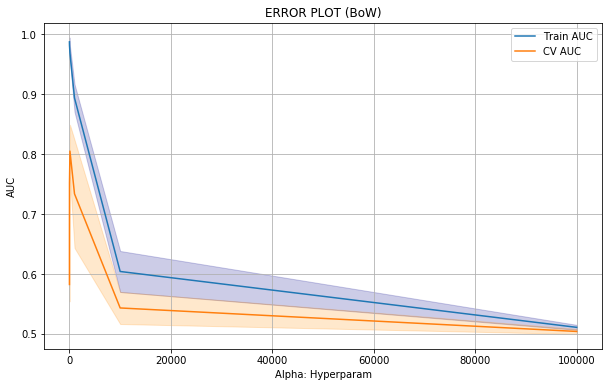

CPU times: user 29.2 s, sys: 552 ms, total: 29.8 s
Wall time: 28.1 s
Optimal value of Alpha:  {'alpha': 100}


In [10]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_bigram,test=X_test_bigram,mean=False)
#HYPERPARAM TUNNING
%time model=NB_Classifier(train,y_train,TBS,params,searchMethod,vect[0])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of Alpha: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_bow_mnb')

#### [1.2] Performance on test data with optimal value of hyperparam<font color='red'> SET 1</font>

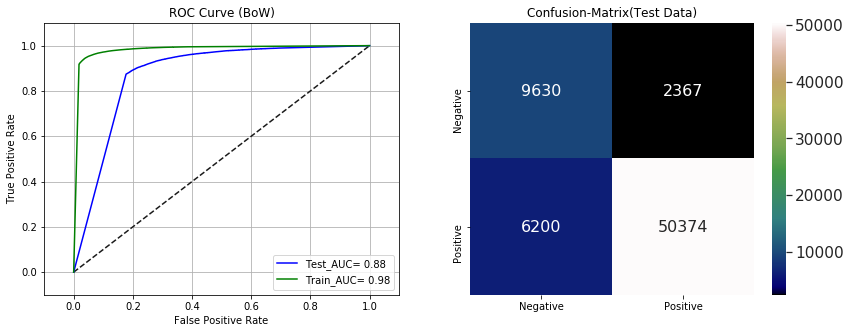

In [11]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['alpha'],vect[0],summarize)

#### [1.3] Top 10 important features of positive and negative class from<font color='red'> SET 1</font>

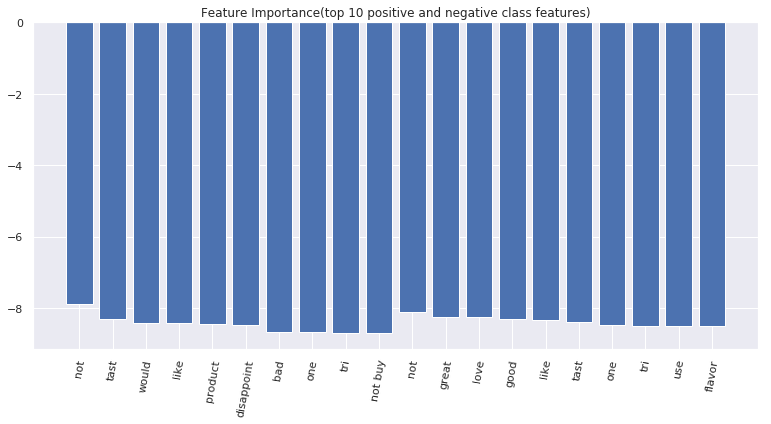

+-------+---------------+------------------+---------------+------------------+
| S.No. | Log-Proba-Neg | Negative-Feature | Log-Proba-Pos | Positive-Feature |
+-------+---------------+------------------+---------------+------------------+
|   1   |    -7.8959    |       not        |    -8.1201    |       not        |
|   2   |    -8.3074    |       tast       |    -8.2480    |      great       |
|   3   |    -8.4258    |      would       |    -8.2497    |       love       |
|   4   |    -8.4264    |       like       |    -8.3044    |       good       |
|   5   |    -8.4593    |     product      |    -8.3372    |       like       |
|   6   |    -8.4722    |    disappoint    |    -8.3892    |       tast       |
|   7   |    -8.6593    |       bad        |    -8.4849    |       one        |
|   8   |    -8.6718    |       one        |    -8.4891    |       tri        |
|   9   |    -8.6868    |       tri        |    -8.5090    |       use        |
|   10  |    -8.6984    |     not buy   

In [12]:
#NO. OF IMPORTANT FEATURE TO DISPLAY
no_of_imp_features=10
#INITIALIZE PRETTYTABLE OBJECT
top_features=PrettyTable()
top_features.field_names=['S.No.','Log-Proba-Neg','Negative-Feature','Log-Proba-Pos','Positive-Feature']
feature_importance(count_vect,clf,no_of_imp_features,top_features)
print(top_features)

###  [2.] Naive Bayes on BOW with Feature Engineering,<font color='red'> SET 1</font>

#### [2.1] Hyperparam Tunning<font color='red'> SET 1</font>

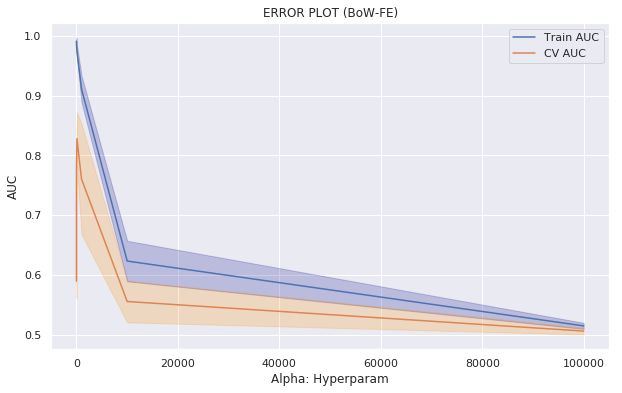

CPU times: user 30.9 s, sys: 520 ms, total: 31.4 s
Wall time: 29.6 s
Optimal value of Alpha:  {'alpha': 100}


In [13]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_bigram_fe,test=X_test_bigram_fe,mean=False)
#HYPERPARAM TUNNING
%time model=NB_Classifier(train,y_train,TBS,params,searchMethod,vect[1])
#PRINT OPTIMAL VALUE OF HYPERPARAM
print('Optimal value of Alpha: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_bowfe_mnb')

#### [2.2] Performance on test data with optimal value of hyperparam<font color='red'> SET 1</font>

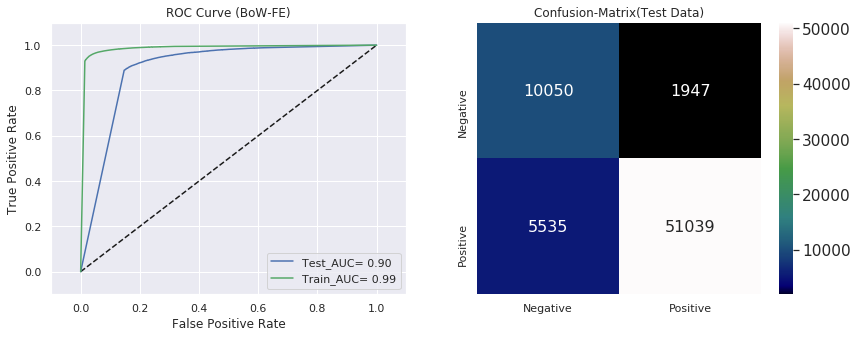

In [14]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['alpha'],vect[1],summarize)

### Observation:
1. from the above BOW vectors without feature engineering and BOW vectors with feature engineering we can observe that AUC score is improved from '.877' to '.898'.  

### [3.] Naive Bayes on TFIDF,<font color='red'> SET 2</font>

#### [3.1] Hyperparam Tunning<font color='red'> SET 2</font>

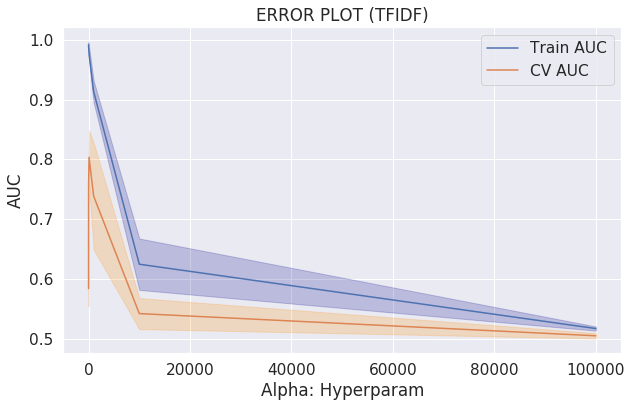

CPU times: user 28.9 s, sys: 604 ms, total: 29.5 s
Wall time: 28 s
Optimal value of Alpha:  {'alpha': 100}


In [15]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_tfidf,test=X_test_tfidf,mean=False)
#HYPERPARAM TUNNING
%time model=NB_Classifier(train,y_train,TBS,params,searchMethod,vect[2])
print('Optimal value of Alpha: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfidf_mnb')

#### [3.2] Performance on test data with optimal value of hyperparam<font color='red'> SET 2</font>

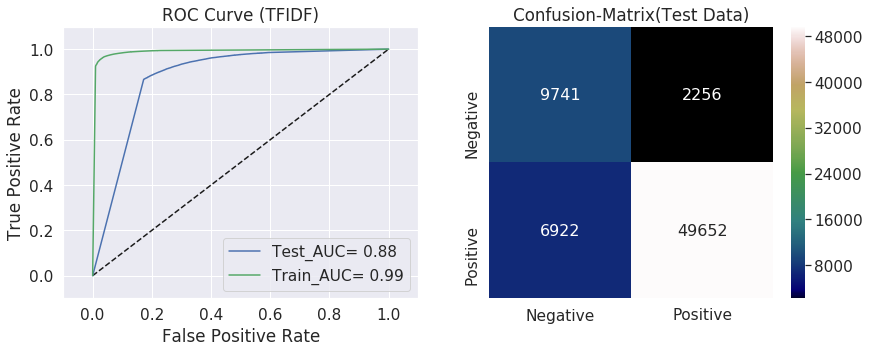

In [16]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['alpha'],vect[2],summarize)

#### [3.3] Top 10 important features of positive and negative class from<font color='red'> SET 2</font>

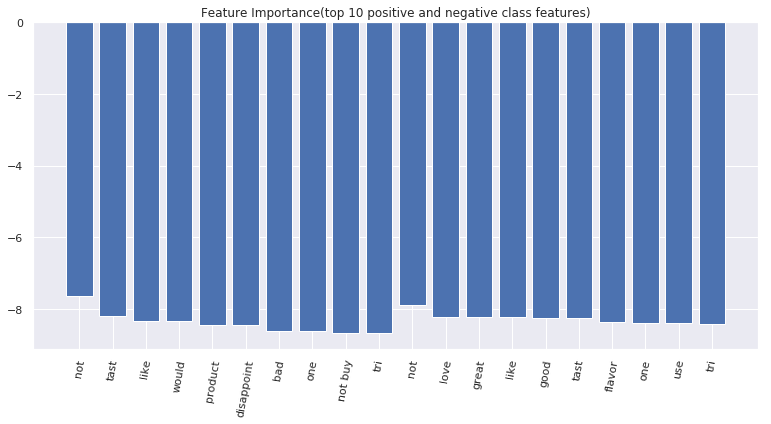

+-------+---------------+------------------+---------------+------------------+
| S.No. | Log-Proba-Neg | Negative-Feature | Log-Proba-Pos | Positive-Feature |
+-------+---------------+------------------+---------------+------------------+
|   1   |    -7.6394    |       not        |    -7.9056    |       not        |
|   2   |    -8.2048    |       tast       |    -8.2189    |       love       |
|   3   |    -8.3319    |       like       |    -8.2302    |      great       |
|   4   |    -8.3336    |      would       |    -8.2387    |       like       |
|   5   |    -8.4429    |     product      |    -8.2532    |       good       |
|   6   |    -8.4443    |    disappoint    |    -8.2669    |       tast       |
|   7   |    -8.6207    |       bad        |    -8.3704    |      flavor      |
|   8   |    -8.6223    |       one        |    -8.3885    |       one        |
|   9   |    -8.6737    |     not buy      |    -8.3976    |       use        |
|   10  |    -8.6749    |       tri     

In [17]:
#NO. OF IMPORTANT FEATURE TO DISPLAY
no_of_imp_features=10
#INITIALIZE PRETTYTABLE OBJECT
top_features_tf=PrettyTable()
top_features_tf.field_names=['S.No.','Log-Proba-Neg','Negative-Feature','Log-Proba-Pos','Positive-Feature']
feature_importance(tf_idf_vect,clf,no_of_imp_features,top_features_tf)
print(top_features_tf)

###  [4.] Naive Bayes on TFIDF with Feature Engineering,<font color='red'> SET 2</font>

#### [4.1] Hyperparam Tunning<font color='red'> SET 2</font>

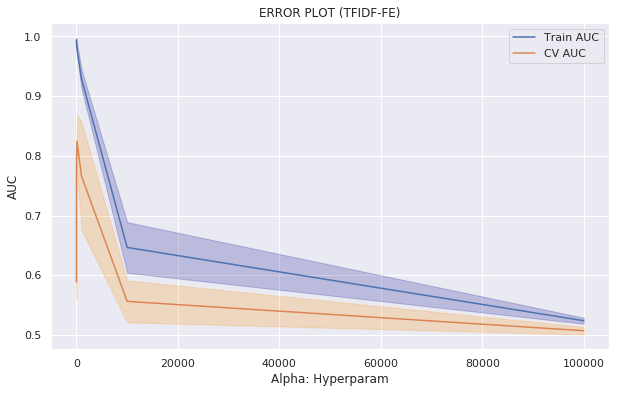

CPU times: user 30.5 s, sys: 576 ms, total: 31.1 s
Wall time: 29.3 s
Optimal value of Alpha:  {'alpha': 100}


In [18]:
#STANDARDIZE TRAIN AND TEST DATA
train, test=std_data(train=X_train_tfidf_fe,test=X_test_tfidf_fe,mean=False)
#HYPERPARAM TUNNING
%time model=NB_Classifier(train,y_train,TBS,params,searchMethod,vect[3])
print('Optimal value of Alpha: ',model.best_params_)
#SAVE CURRENT STATE OF ML-MODEL FOR FUTURE USE
saveModeltofile(model,'model_tfidffe_mnb')

#### [4.2] Performance on test data with optimal value of hyperparam<font color='red'> SET 2</font>

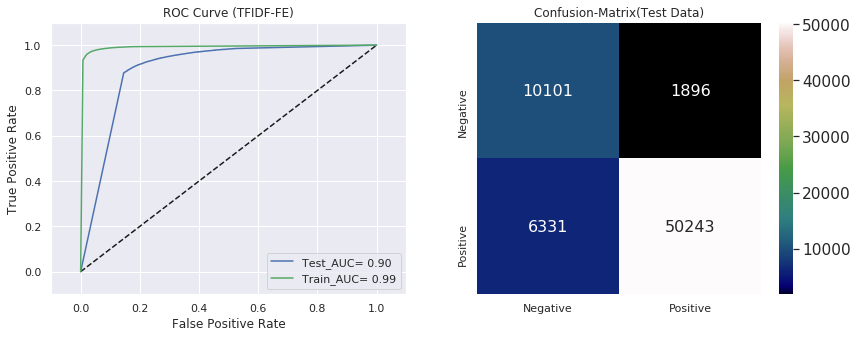

In [19]:
clf=test_performance(train,y_train,test,y_test,model.best_params_['alpha'],vect[3],summarize)

### Observation:
1. from the above TFIDF vectors without feature engineering and TFIDF vectors with feature engineering we can observe that AUC score is improved from '.877' to '.896'.  

## Conclusions:

In [21]:
print(summarize)

+------------+---------------+-----------+----------------+
| Vectorizer | Optimal-alpha | Test(AUC) | Test(f1-score) |
+------------+---------------+-----------+----------------+
|    BoW     |      100      |   0.877   |     0.881      |
|   BoW-FE   |      100      |   0.898   |     0.896      |
|   TFIDF    |      100      |   0.877   |     0.874      |
|  TFIDF-FE  |      100      |   0.896   |     0.887      |
+------------+---------------+-----------+----------------+


1. from the above table we can observe that the optimal performance is obtained by:
        a. Bag Of Word vectorizer with new features(such as 'length of reviews')
        b. f1-score=.896 and auc=.898